# Fintech Project (HousePricing Prediction)
predict house prices using **regression trees, random forest, and neural networks.**
- Follows ML pipeline practices: data loading, cleaning, feature engineering, modeling, evaluation, and interpretability.


## Prerequisites for Running

- **Python 3.8+**
- **Google Colab** or any environment with GPU (for faster neural network training)
- **Libraries:**
    - pandas, numpy, matplotlib, seaborn
    - scikit-learn (≥1.3 recommended)
    - tensorflow (2.13 or 2.18 recommended)
    - scikeras (0.11.0)
    - shap
- **Dataset:** Provided `housePricingDS.csv` in your Google Drive at `/content/drive/MyDrive/fintech/`
  - or upload in notebook and uncomment this line:

    ```
    #hp = pd.read_csv('housePricingDS.csv', sep=';')
    ```


- If running outside Colab, install requirements using:
    ```bash
    pip install pandas numpy matplotlib seaborn scikit-learn tensorflow scikeras shap
    ```
### **How to run**

1. Open this notebook in Google Colab.
2. Mount your Google Drive.
3. Ensure the dataset file (`housePricingDS.csv`) is in the specified Drive folder.
4. Run all cells from top to bottom.

### **GPU acceleration**

- The Neural Network part will **automatically use GPU/CUDA** if you enable "GPU" in Colab (`Runtime > Change runtime type > GPU`).


# Setup environment

In [ ]:
!pip install "tensorflow==2.18.0" "scikeras==0.11.0" scikit-learn --quiet

# Restart runtime session
import os
os.kill(os.getpid(), 9)

# Import LIbraries

In [1]:
# !pip install seaborn matplotlib --quiet
# !pip install -U shap --quiet

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import seaborn as sbn
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import RandomizedSearchCV

In [2]:
import tensorflow as tf
from tensorflow import keras
from scikeras.wrappers import KerasRegressor
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler

In [3]:
sbn.set(style="whitegrid", palette="muted", font_scale=1.2)

# Load DATASET

In [4]:
# --- Data Loading ---
# Mount Google Drive and load dataset (required due to Colab file upload limits).

from google.colab import drive
drive.mount('/content/drive')

#hp = pd.read_csv('housePricingDS.csv', sep=';')
hp = pd.read_csv('/content/drive/MyDrive/fintech/housePricingDS.csv', sep=';') # from google drive
print(hp.shape)
print(hp.columns)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(21613, 21)
Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')


# Data Exploration

In [5]:
hp.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [6]:
hp.describe()

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
count,2.161300e+04,2.161300e+04,21613.000000,21613.000000,21613.000000,2.161300e+04,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000,21613.000000
mean,4.580302e+09,5.401822e+05,3.370842,2.114757,2079.899736,1.510697e+04,1.494309,0.007542,0.234303,3.409430,7.656873,1788.390691,291.509045,1971.005136,84.402258,98077.939805,47.560053,-122.213896,1986.552492,12768.455652
std,2.876566e+09,3.673622e+05,0.930062,0.770163,918.440897,4.142051e+04,0.539989,0.086517,0.766318,0.650743,1.175459,828.090978,442.575043,29.373411,401.679240,53.505026,0.138564,0.140828,685.391304,27304.179631
min,1.000102e+06,7.500000e+04,0.000000,0.000000,290.000000,5.200000e+02,1.000000,0.000000,0.000000,1.000000,1.000000,290.000000,0.000000,1900.000000,0.000000,98001.000000,47.155900,-122.519000,399.000000,651.000000
25%,2.123049e+09,3.219500e+05,3.000000,1.750000,1427.000000,5.040000e+03,1.000000,0.000000,0.000000,3.000000,7.000000,1190.000000,0.000000,1951.000000,0.000000,98033.000000,47.471000,-122.328000,1490.000000,5100.000000
50%,3.904930e+09,4.500000e+05,3.000000,2.250000,1910.000000,7.618000e+03,1.500000,0.000000,0.000000,3.000000,7.000000,1560.000000,0.000000,1975.000000,0.000000,98065.000000,47.571800,-122.230000,1840.000000,7620.000000
75%,7.308900e+09,6.450000e+05,4.000000,2.500000,2550.000000,1.068800e+04,2.000000,0.000000,0.000000,4.000000,8.000000,2210.000000,560.000000,1997.000000,0.000000,98118.000000,47.678000,-122.125000,2360.000000,10083.000000
max,9.900000e+09,7.700000e+06,33.000000,8.000000,13540.000000,1.651359e+06,3.500000,1.000000,4.000000,5.000000,13.000000,9410.000000,4820.000000,2015.000000,2015.000000,98199.000000,47.777600,-121.315000,6210.000000,871200.000000


# Prepare dataset

>Data Cleaning & Exploration
>
> - Check for null values, remove unused columns, and visualize target variable distribution.




**1. check for null values to be removed (Data Cleaning)**



In [7]:
print(hp.isnull().sum())

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


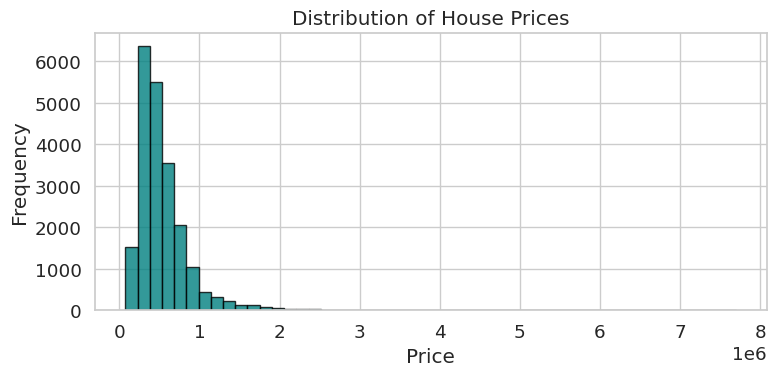

In [8]:
plt.figure(figsize=(8, 4))
plt.hist(hp['price'], bins=50, color='teal', edgecolor='black', alpha=0.8)
plt.title('Distribution of House Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

**2. Drop not needed columns**

In [9]:
hp = hp.drop(['id', 'date'], axis=1)

**3. Define feature points & output**

>X (features) and y (target: price).

In [10]:
y = hp['price']
X = hp.drop('price', axis=1)
print(X.shape)
print(y.shape)

(21613, 18)
(21613,)


Split Train & Test & Validation data

> Train: 60%,
> Test: 20%,
> Validation: 20%



In [11]:
from sklearn.model_selection import train_test_split
seed = 34
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=seed)

# Helper Performance methods

In [12]:
# to round to decimal numbers
def round_n(num, n=2):
    return f"{num:,.{n}f}"

In [13]:
def compare_metrics(rmse, r2, avg_price, mean_error, std_error, set_name=""):
  # Compare regression model performance metrics (RMSE and R^2) against the average price.

    rmse_p = (rmse / avg_price) * 100

    if set_name != "": # to print only if we have set name
      print(f"\n--- {set_name} Evaluation ---")

    print(f"Average house price: ${round_n(avg_price)}")
    print(f"Mean Error: {round_n(mean_error, 3)}")
    print(f"Std of Error: {round_n(std_error)}")
    print(f"RMSE: ${round_n(rmse)} ({rmse_p:.1f}% of avg price)")
    print(f"R²: {round_n(r2)}")

    if rmse_p < 20:
        print("1) Excellent -> RMSE is less than 20% of mean price.")
    elif rmse_p < 40:
        print("1) Good -> RMSE is less than 40% of mean price.")
    elif rmse_p < 60:
        print("1) Fair -> RMSE is less than 60% of mean price, but can be improved.")
    else:
        print("1) Poor -> RMSE is high relative to average price; model likely underfitting or data is complex.")

    if r2 > 0.8:
        print("2) High R² -> Model explains most of the variance.")
    elif r2 > 0.6:
        print("2) Moderate R² -> Model explains a decent amount of variance.")
    elif r2 > 0.3:
        print("2) Low R² -> Model only explains a small part of the variance.")
    else:
        print("2) R² is very low -> Model does not explain much of the variance.")

In [14]:
"""
    Evaluate regression model's performance on a given dataset.

    Parameters:
    - y_true: Real values.
    - y_pred: Model prediction values.
    - set_name: String label for defining set.
    - print_comparison: If True, run and print comparison metrics.

    Returns:
    - rmse: Root mean squared error.
    - r2: R squared metric.
    - mean_error: Mean prediction error.
    - std_error: Standard deviation of error.
    """
def evaluate_model(y_true, y_pred, set_name, print_comparison=True):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    avg_price = y_true.mean()
    error = y_pred - y_true
    mean_error = np.mean(error)
    std_error = np.std(error)

    if print_comparison:
      compare_metrics(rmse, r2, y_true.mean(), mean_error, std_error, set_name)

    return rmse, r2, mean_error, std_error

# Baseline (naive) predicition

> Simple mean-based prediction for reference; used to benchmark all advanced models.

In [15]:
def baseline_pred():
    baseline_pred = [y_train.mean()] * len(y_test)
    baseline_rmse = np.sqrt(mean_squared_error(y_test, baseline_pred))
    baseline_r2 = r2_score(y_test, baseline_pred)
    return baseline_rmse, baseline_r2

In [16]:
baseline_rmse, baseline_r2 = baseline_pred()
print(f"Baseline RMSE: ${round_n(baseline_rmse)}")
print(f"Baseline R²: {baseline_r2:.3f}")

Baseline RMSE: $415,582.67
Baseline R²: -0.001


In [17]:
def compare_to_baseline(rmse_model, r2_model):
  print("\n--- Model Comparison to Baseline ---")
  print(f"RMSE improvement: {round_n(baseline_rmse - rmse_model)} ({((baseline_rmse - rmse_model)/baseline_rmse)*100:.1f}% lower than baseline)")
  print(f"R² improvement: {r2_model - baseline_r2:.2f} higher than baseline")

# **1- Regression Tree**

> Train and evaluate a single DecisionTreeRegressor, tune max_depth, plot feature importances.

#### **1.0 Setup the model**

In [18]:
reg_tree = DecisionTreeRegressor(criterion='squared_error', max_depth=10, random_state=0)
reg_tree.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=10, random_state=0)

for "max_depth" values more than 10 :
- much better results for Train set:
  - 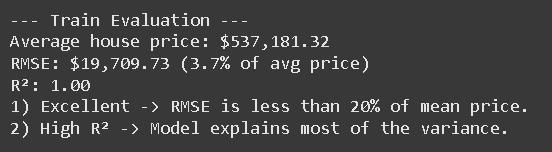
- we bend to overfitting and much poor results for both Validation & Test sets.

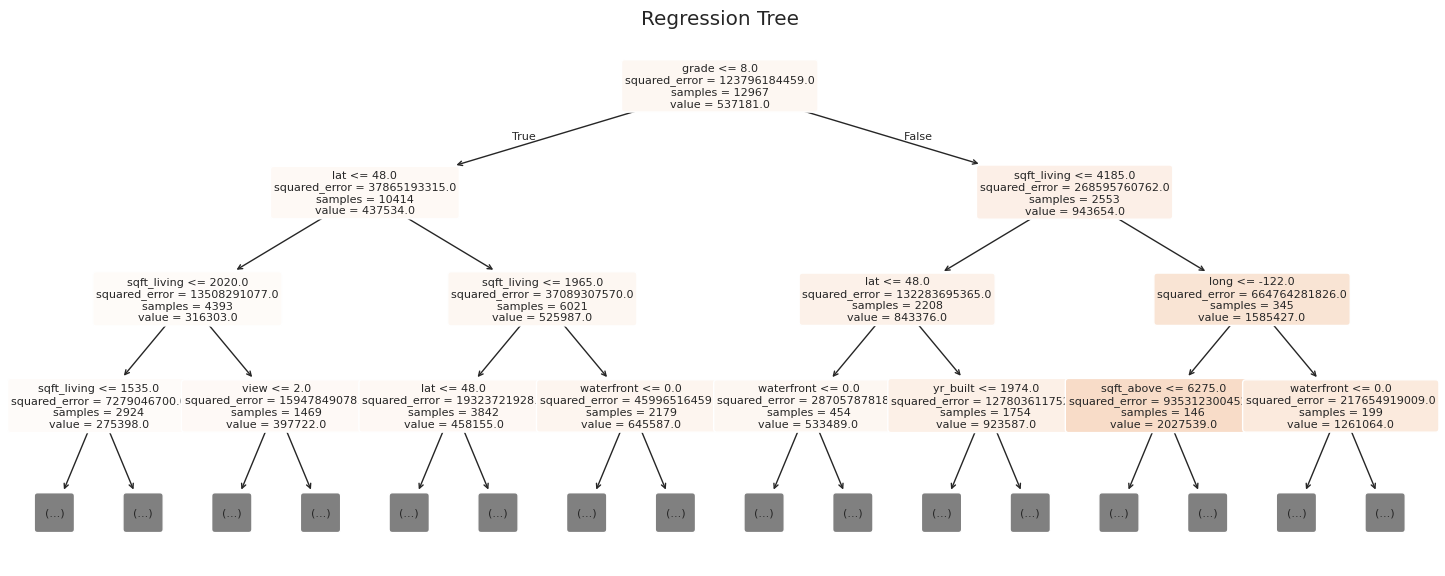

In [20]:
# plot only with max_depth= 3 so to not take too much time and corrupted plot
plt.figure(figsize=(15, 6))
plot_tree(
    reg_tree,
    feature_names=X_train.columns,
    filled=True,
    rounded=True,
    precision=0,
    fontsize=8,
    max_depth=3
)
plt.title("Regression Tree")
plt.tight_layout()
plt.savefig('tree_plot.png', dpi=300)
plt.show()

#### **1.1 Run Prediction**

In [20]:
y_pred_train = reg_tree.predict(X_train)
evaluate_model(y_train, y_pred_train, "Train");


--- Train Evaluation ---
Average house price: $537,181.32
Mean Error: 0.000
Std of Error: 101,110.55
RMSE: $101,110.55 (18.8% of avg price)
R²: 0.92
1) Excellent -> RMSE is less than 20% of mean price.
2) High R² -> Model explains most of the variance.


In [21]:
y_pred_val = reg_tree.predict(X_val)
evaluate_model(y_val, y_pred_val, "Validation");


--- Validation Evaluation ---
Average house price: $542,073.20
Mean Error: 355.258
Std of Error: 164,941.20
RMSE: $164,941.58 (30.4% of avg price)
R²: 0.79
1) Good -> RMSE is less than 40% of mean price.
2) Moderate R² -> Model explains a decent amount of variance.


In [22]:
y_pred_test = reg_tree.predict(X_test)
rmse, r2, mean_err, std_err = evaluate_model(y_test, y_pred_test, "Test")
compare_to_baseline(rmse, r2)


--- Test Evaluation ---
Average house price: $547,292.25
Mean Error: -6,665.585
Std of Error: 181,852.52
RMSE: $181,974.64 (33.2% of avg price)
R²: 0.81
1) Good -> RMSE is less than 40% of mean price.
2) High R² -> Model explains most of the variance.

--- Model Comparison to Baseline ---
RMSE improvement: 233,608.03 (56.2% lower than baseline)
R² improvement: 0.81 higher than baseline


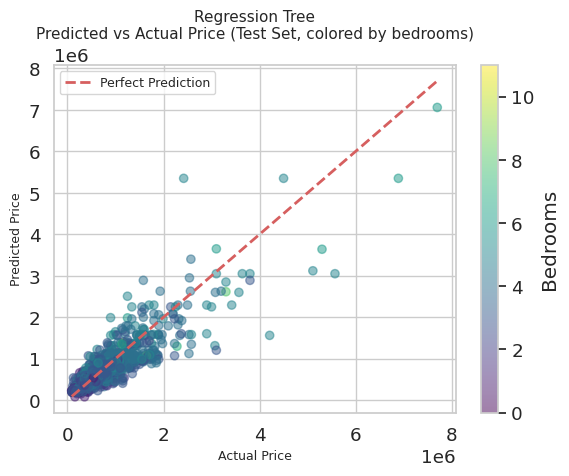

In [23]:
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_pred_test, alpha=0.5, c=X_test['bedrooms'], cmap='viridis')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2, label='Perfect Prediction')
plt.xlabel("Actual Price", fontsize=9)
plt.ylabel("Predicted Price", fontsize=9)
plt.title("Regression Tree\nPredicted vs Actual Price (Test Set, colored by bedrooms)", fontsize=11)
plt.colorbar(label='Bedrooms')
plt.legend(fontsize=9)
plt.tight_layout()
plt.show()

#### **1.2 Interpretibility (Feature Importance)**

In [29]:
feature_importance_values = pd.Series(reg_tree.feature_importances_, index=X_train.columns)

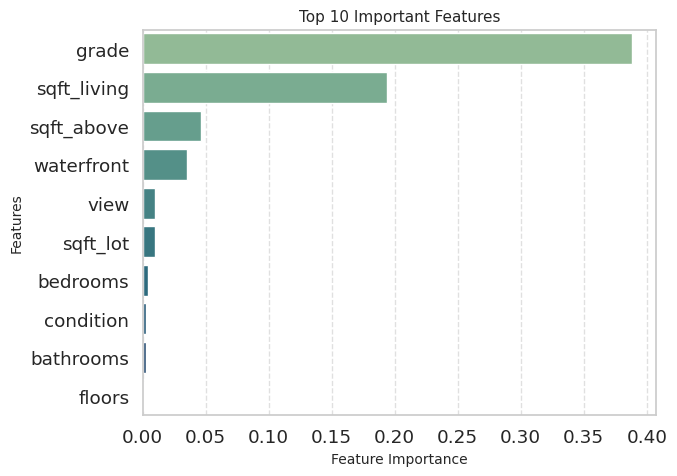

In [30]:
top_importances = feature_importance_values.head(10).sort_values(ascending=False)

top_importances_df = top_importances.reset_index()
top_importances_df.columns = ['Feature', 'Importance']

plt.figure(figsize=(7, 5))
sbn.barplot(
    x='Importance',
    y='Feature',
    hue='Feature',
    data=top_importances_df,
    palette='crest',
    dodge=False,
    legend=False
)
plt.xlabel("Feature Importance", fontsize=10)
plt.ylabel("Features", fontsize=10)
plt.title("Top 10 Important Features", fontsize=11)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


# **2- Random Forest**

> Train and evaluate, tune hyperparameters with RandomizedSearchCV, plot top features.

#### **2.1 Model initial setup**

In [24]:
rf = RandomForestRegressor(random_state=0)
rf.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [25]:
y_rf_train = rf.predict(X_train)
evaluate_model(y_train, y_rf_train, "Train");


--- Train Evaluation ---
Average house price: $537,181.32
Mean Error: -167.757
Std of Error: 47,757.61
RMSE: $47,757.91 (8.9% of avg price)
R²: 0.98
1) Excellent -> RMSE is less than 20% of mean price.
2) High R² -> Model explains most of the variance.


In [26]:
y_rf_val = rf.predict(X_val)
evaluate_model(y_val, y_rf_val, "Validation");


--- Validation Evaluation ---
Average house price: $542,073.20
Mean Error: 637.159
Std of Error: 124,112.31
RMSE: $124,113.94 (22.9% of avg price)
R²: 0.88
1) Good -> RMSE is less than 40% of mean price.
2) High R² -> Model explains most of the variance.


In [27]:
y_rf_test = rf.predict(X_test)
rmse, r2, mean_err, std_err = evaluate_model(y_test, y_rf_test, "Test")
compare_to_baseline(rmse, r2)


--- Test Evaluation ---
Average house price: $547,292.25
Mean Error: -2,537.453
Std of Error: 153,934.78
RMSE: $153,955.69 (28.1% of avg price)
R²: 0.86
1) Good -> RMSE is less than 40% of mean price.
2) High R² -> Model explains most of the variance.

--- Model Comparison to Baseline ---
RMSE improvement: 261,626.98 (63.0% lower than baseline)
R² improvement: 0.86 higher than baseline


#### **2.2 Search for optimal hyperparameters**
> RandomizedSearchCV for Random Forest

In [28]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 15, 20, 25, None],
    'min_samples_leaf': [1, 2, 4]
}

rf = RandomForestRegressor(random_state=0)

In [30]:
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_grid,
    n_iter=4,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    random_state=0
)
random_search.fit(X_train, y_train)
print("Optimal Parameters:", random_search.best_params_)
print("Optimal RMSE:", -random_search.best_score_)

Fitting 3 folds for each of 4 candidates, totalling 12 fits
Optimal Parameters: {'n_estimators': 100, 'min_samples_leaf': 1, 'max_depth': None}
Optimal RMSE: 131666.6863192101


#### **2.3 Retrain Random forest with found search results**

In [31]:
rf_tuned = RandomForestRegressor(
    n_estimators=100,
    max_depth=None,
    min_samples_leaf=1,
    random_state=0
)

rf_tuned.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [32]:
y_rf_train_tuned = rf_tuned.predict(X_train)
y_rf_val_tuned = rf_tuned.predict(X_val)
y_rf_test_tuned = rf_tuned.predict(X_test)

print("\nRandom Forest (Tuned) Metrics")
evaluate_model(y_train, y_rf_train_tuned, set_name="Train")
evaluate_model(y_val, y_rf_val_tuned, set_name="Validation")
tuned_rmse, tuned_r2, tuned_mean_err, tuned_std = evaluate_model(y_test, y_rf_test_tuned, set_name="Test")
compare_to_baseline(tuned_rmse, tuned_r2)


Random Forest (Tuned) Metrics

--- Train Evaluation ---
Average house price: $537,181.32
Mean Error: -167.757
Std of Error: 47,757.61
RMSE: $47,757.91 (8.9% of avg price)
R²: 0.98
1) Excellent -> RMSE is less than 20% of mean price.
2) High R² -> Model explains most of the variance.

--- Validation Evaluation ---
Average house price: $542,073.20
Mean Error: 637.159
Std of Error: 124,112.31
RMSE: $124,113.94 (22.9% of avg price)
R²: 0.88
1) Good -> RMSE is less than 40% of mean price.
2) High R² -> Model explains most of the variance.

--- Test Evaluation ---
Average house price: $547,292.25
Mean Error: -2,537.453
Std of Error: 153,934.78
RMSE: $153,955.69 (28.1% of avg price)
R²: 0.86
1) Good -> RMSE is less than 40% of mean price.
2) High R² -> Model explains most of the variance.

--- Model Comparison to Baseline ---
RMSE improvement: 261,626.98 (63.0% lower than baseline)
R² improvement: 0.86 higher than baseline


**NOTE:**
**`Results not changed much after fine tuning with best params as random forest is almost a strong model on itself and the default values could get the best results it could find`**

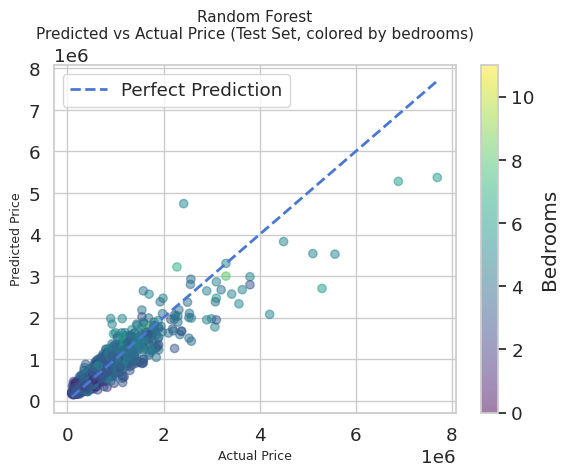

In [54]:
plt.figure(figsize=(6,5))
plt.scatter(y_test, y_rf_test_tuned, alpha=0.5, c=X_test['bedrooms'], cmap='viridis')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'b--', lw=2, label='Perfect Prediction')
plt.xlabel("Actual Price", fontsize=9)
plt.ylabel("Predicted Price", fontsize=9)
plt.title("Random Forest\nPredicted vs Actual Price (Test Set, colored by bedrooms)", fontsize=11)
plt.colorbar(label='Bedrooms')
plt.legend()
plt.tight_layout()
plt.show()

#### **2.4 Interpretability  (Feature Importance Analysis)**

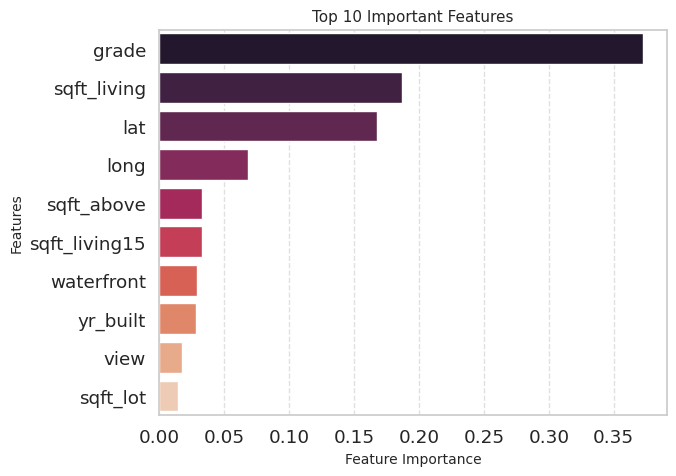

In [34]:
importances_rf = pd.Series(rf_tuned.feature_importances_, index=X_train.columns)
importances_rf = importances_rf.sort_values(ascending=False)


top_importances = importances_rf.head(10).sort_values(ascending=False)

top_importances_df = top_importances.reset_index()
top_importances_df.columns = ['Feature', 'Importance']

plt.figure(figsize=(7, 5))
sbn.barplot(
    x='Importance',
    y='Feature',
    hue='Feature',
    data=top_importances_df,
    palette='rocket',
    dodge=False,
    legend=False
)
plt.xlabel("Feature Importance", fontsize=10)
plt.ylabel("Features", fontsize=10)
plt.title("Top 10 Important Features", fontsize=11)
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# **3- Neural Network**
> Standardize features, modular model building, manual grid search for hyperparameters.

**Implementation Notes**

- **Manual Hyperparameter Search for Neural Networks:**  
  Due to known incompatibilities between the latest Keras/TensorFlow/Scikit-learn and their wrappers (such as SciKeras) in Google Colab, automatic hyperparameter search (`GridSearchCV`, `RandomizedSearchCV`) often fails with errors.  
  Manual grid search is used for robustness and transparency, providing full control over model training and tuning. This approach allows precise tracking and reporting of all tried configurations.

**3.1 initial setup**

In [35]:
np.random.seed(seed)
tf.random.set_seed(seed)

scaler_X = StandardScaler()
scaler_y = StandardScaler()

**3.2 Scale the data**

In [36]:
X_train_scaled = scaler_X.fit_transform(X_train)
X_val_scaled   = scaler_X.transform(X_val)
X_test_scaled  = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_val_scaled   = scaler_y.transform(y_val.values.reshape(-1, 1)).flatten()
y_test_scaled  = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

#### **3.3 organize modelling in methods**

In [37]:
def build_nn_model(
    input_dim,
    hidden_layers=[64, 32],
    activation='relu',
    optimizer='adam',
    loss='mse',
    metrics=['mae']
):
    model = keras.models.Sequential()
    model.add(layers.Input(shape=(input_dim,)))
    for units in hidden_layers:
        model.add(layers.Dense(units, activation=activation))
    model.add(layers.Dense(1, activation='linear'))
    model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    return model

In [38]:
def inverse_transform_preds(pred_scaled, scaler_y):
    return scaler_y.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()

In [39]:
"""
    Train and validate a Neural Network regressor with given hyperparameters.
    Returns model, history, and predictions for train/val/test.
"""
def run_NN(
    X_train_scaled, y_train_scaled, X_val_scaled, y_val_scaled, X_test_scaled, scaler_y,
    hidden_layers=[64, 32], activation='relu', optimizer='adam', loss='mse', metrics=['mae'],
    batch_size=64, epochs=200, patience=20, verbose=0
):
    if verbose > 0:
      print("Starting Neural Network modelling")

    input_dim = X_train_scaled.shape[1]
    model = build_nn_model(
        input_dim=input_dim,
        hidden_layers=hidden_layers,
        activation=activation,
        optimizer=optimizer,
        loss=loss,
        metrics=metrics
    )
    if verbose > 0:
      print("in progress....")

    # Set up Early Stopping to prevent overfitting
    early_stop = keras.callbacks.EarlyStopping(patience=patience, restore_best_weights=True)
    history = model.fit(
        X_train_scaled, y_train_scaled,
        validation_data=(X_val_scaled, y_val_scaled),
        epochs=epochs,
        batch_size=batch_size,
        callbacks=[early_stop],
        verbose=verbose
    )

     # Generate predictions for the training, validation, and test sets
    # Inverse transform the scaled predictions back to the original scale
    y_pred_train = inverse_transform_preds(model.predict(X_train_scaled).flatten(), scaler_y)
    y_pred_val   = inverse_transform_preds(model.predict(X_val_scaled).flatten(), scaler_y)
    y_pred_test  = inverse_transform_preds(model.predict(X_test_scaled).flatten(), scaler_y)

    if verbose > 0:
      print("Finished Neural Network modelling")

    return {
        'model': model,
        'history': history,
        'y_pred_train': y_pred_train,
        'y_pred_val': y_pred_val,
        'y_pred_test': y_pred_test
    }


#### **3.4 Running with initial random params to check model performance**

In [40]:
nn_results = run_NN(
    X_train_scaled, y_train_scaled,
    X_val_scaled, y_val_scaled,
    X_test_scaled, scaler_y,
    hidden_layers=[64, 32],
    activation='relu',
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='mse',
    batch_size=64,
    epochs=100,
    patience=20,
    verbose=0
)

406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [41]:
evaluate_model(y_train, nn_results['y_pred_train'], "Train")
evaluate_model(y_val, nn_results['y_pred_val'], "Validation")
rmse, r2, mean_err, std = evaluate_model(y_test, nn_results['y_pred_test'], "Test")
compare_to_baseline(rmse, r2)


--- Train Evaluation ---
Average house price: $537,181.32
Mean Error: 3,378.089
Std of Error: 93,370.10
RMSE: $93,431.18 (17.4% of avg price)
R²: 0.93
1) Excellent -> RMSE is less than 20% of mean price.
2) High R² -> Model explains most of the variance.

--- Validation Evaluation ---
Average house price: $542,073.20
Mean Error: 4,046.133
Std of Error: 128,459.35
RMSE: $128,523.06 (23.7% of avg price)
R²: 0.87
1) Good -> RMSE is less than 40% of mean price.
2) High R² -> Model explains most of the variance.

--- Test Evaluation ---
Average house price: $547,292.25
Mean Error: 1,180.410
Std of Error: 140,488.63
RMSE: $140,493.59 (25.7% of avg price)
R²: 0.89
1) Good -> RMSE is less than 40% of mean price.
2) High R² -> Model explains most of the variance.

--- Model Comparison to Baseline ---
RMSE improvement: 275,089.09 (66.2% lower than baseline)
R² improvement: 0.89 higher than baseline


#### ***3.5 Hyperparameter Tuning***


> preparing list of param options to find optimal combination

In [42]:
from itertools import product

hidden_layers_options = [
    [128, 64],
    [64, 32],
    [32, 16, 8]
]
activation_options = ['relu', 'tanh']
lr_options = [0.001]
loss_options = ['mse', 'mae', 'log_cosh']

In [43]:
param_grid = []
for hl, act, lr, loss in product(hidden_layers_options, activation_options, lr_options, loss_options):
    param_grid.append({
        'hidden_layers': hl,
        'activation': act,
        'lr': lr,
        'loss': loss
    })


Doing search like Grid-Search

In [44]:
def search_nn_params(param_grid):
  optimal_rmse = float('inf')
  optimal_result = None
  optimal_params = None

  print(f"Searching with total {len(param_grid)} fits...")
  for params in param_grid:
      result = run_NN(
          X_train_scaled, y_train_scaled,
          X_val_scaled, y_val_scaled,
          X_test_scaled, scaler_y,
          hidden_layers=params['hidden_layers'],
          activation=params['activation'],
          optimizer=keras.optimizers.Adam(learning_rate=params['lr']),
          loss=params['loss'],
          batch_size=64,
          epochs=200,
          patience=20,
          verbose=0
      )
      rmse_val, r2_val, mean_err_val, std_val = evaluate_model(y_val, result['y_pred_val'], "", False)
      if rmse_val < optimal_rmse:
          optimal_rmse = rmse_val
          optimal_result = result
          optimal_params = params.copy()

  # print("\Optimal NN Hyperparameters")
  # for k, v in optimal_params.items():
  #     print(f"{k}: {v}")

  return optimal_result, optimal_params, optimal_rmse

In [45]:
start_time = time.time()
optimal_result, optimal_params, optimal_rmse = search_nn_params(param_grid)
end_time = time.time()

total_time = end_time - start_time
print(f"\nsearch completed in {round_n(total_time / 60)} minutes.")


Searching with total 18 fits...
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
406/406 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
136/136 ━━━━━━━━━━━━━━━━━

In [46]:
params_display = optimal_params.copy()
params_display['optimizer'] = f'Adam(lr={optimal_params["lr"]})'

hyperparams_df = pd.DataFrame(list(params_display.items()), columns=['Parameter', 'Value'])

print("Optimal Neural Network Hyperparameters:")
display(hyperparams_df.style.hide(axis="index"))

print(f"\nOptimal RMSE: {round_n(optimal_rmse)}")

Optimal Neural Network Hyperparameters:


Parameter,Value
hidden_layers,"[64, 32]"
activation,relu
lr,0.001000
loss,log_cosh
optimizer,Adam(lr=0.001)



Optimal RMSE: 121,668.93


**3.6 Retrain the model with tuned parameters**

In [47]:
optimal_params = {
    'hidden_layers': optimal_params['hidden_layers'],
    'activation': optimal_params['activation'],
    'lr': optimal_params.get('lr', 0.001),
    'loss': optimal_params['loss'],
    'batch_size': 64,
    'epochs': 200,
    'patience': 20
}

In [48]:
# Merge train, val
X_full_train = np.concatenate([np.asarray(X_train_scaled), np.asarray(X_val_scaled)])
y_full_train = np.concatenate([np.asarray(y_train_scaled), np.asarray(y_val_scaled)])


optimizer = keras.optimizers.Adam(learning_rate=optimal_params['lr'])
print("retraining with optimal params found")
final_result = run_NN(
    X_full_train, y_full_train,
    X_val_scaled, y_val_scaled,
    X_test_scaled, scaler_y,
    optimizer=optimizer,
    hidden_layers=optimal_params['hidden_layers'],
    activation=optimal_params['activation'],
    loss=optimal_params['loss'],
    epochs=optimal_params['epochs'],
    patience=optimal_params['patience'],
    batch_size=optimal_params['batch_size'],
    verbose=0
)


retraining with optimal params found
541/541 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
136/136 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [49]:
print('\nTuned NN Evaluation:')
final_rmse, final_r2, final_mean_err, final_std = evaluate_model(y_test, final_result['y_pred_test'], 'Test')
compare_to_baseline(final_rmse, final_r2)


Tuned NN Evaluation:

--- Test Evaluation ---
Average house price: $547,292.25
Mean Error: -11,861.132
Std of Error: 151,204.53
RMSE: $151,669.04 (27.7% of avg price)
R²: 0.87
1) Good -> RMSE is less than 40% of mean price.
2) High R² -> Model explains most of the variance.

--- Model Comparison to Baseline ---
RMSE improvement: 263,913.64 (63.5% lower than baseline)
R² improvement: 0.87 higher than baseline


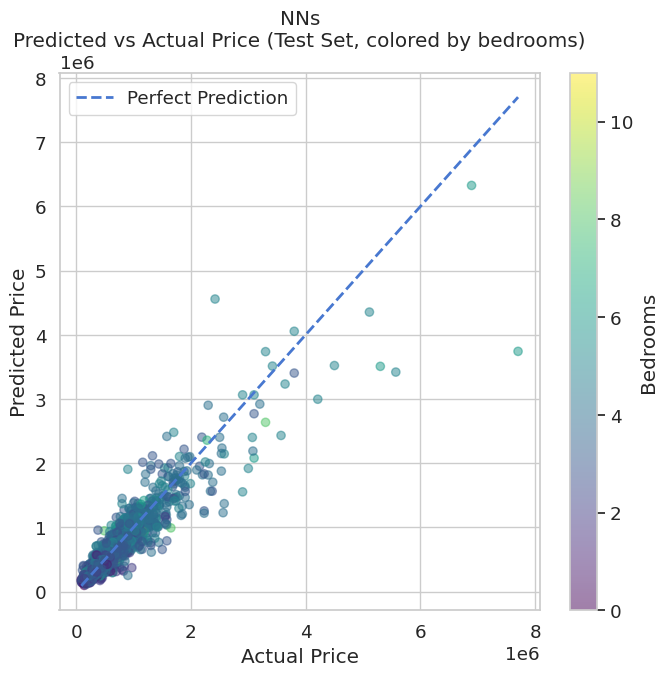

In [55]:
plt.figure(figsize=(7,7))
plt.scatter(y_test, final_result['y_pred_test'], alpha=0.5, c=X_test['bedrooms'], cmap='viridis')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'b--', lw=2, label='Perfect Prediction')
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("NNs\nPredicted vs Actual Price (Test Set, colored by bedrooms)")
plt.colorbar(label='Bedrooms')
plt.legend()
plt.tight_layout()
plt.show()

In [51]:
pd.DataFrame(final_result['history'].history).to_csv("NN_training_history.csv")

#### ***3.7 Plotting results and comparison***

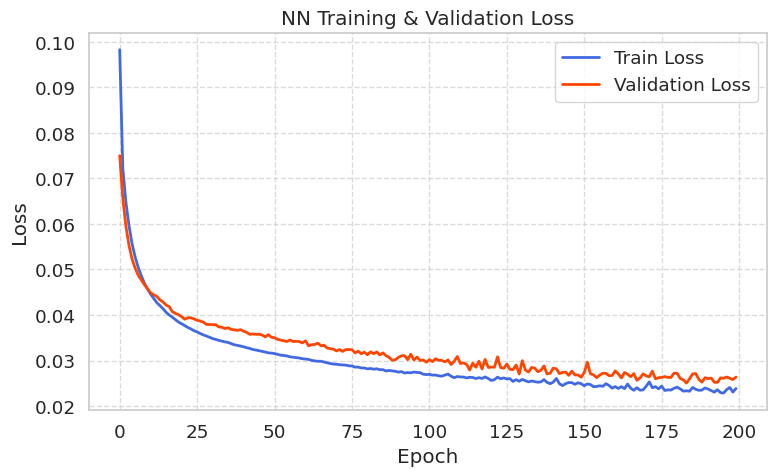

In [57]:
plt.figure(figsize=(8,5))
plt.plot(final_result['history'].history['loss'], label='Train Loss', linewidth=2, color='royalblue')
plt.plot(final_result['history'].history['val_loss'], label='Validation Loss', linewidth=2, color='orangered')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('NN Training & Validation Loss')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


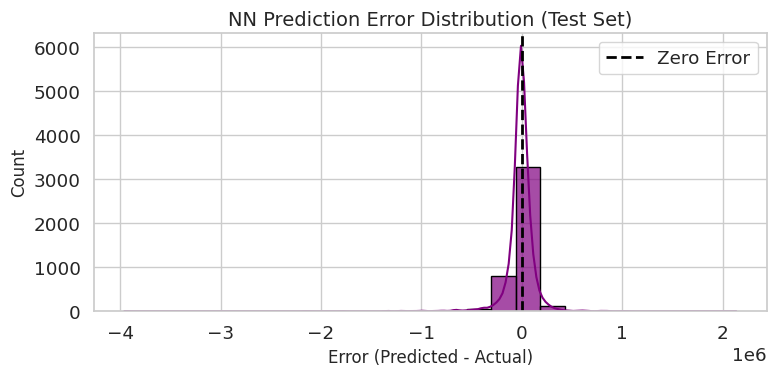

In [65]:
error = final_result['y_pred_test'] - y_test
plt.figure(figsize=(8, 4))
sbn.histplot(error, bins=25, kde=True, color='purple', edgecolor='black', alpha=0.7)
plt.axvline(0, color='black', linestyle='--', linewidth=2, label='Zero Error')
plt.title("NN Prediction Error Distribution (Test Set)", fontsize=14)
plt.xlabel("Error (Predicted - Actual)", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

#### ***3.8 Interpretability (Feature Importance)***

Quantify and visualize feature importance for model explainability.

> ***1- Using Permutation Importance***



In [62]:
from sklearn.inspection import permutation_importance

class KerasModelWrapper:
    def __init__(self, model, scaler_y):
        self.model = model
        self.scaler_y = scaler_y
    def fit(self, X, y):
        return self
    def predict(self, X):
        preds_scaled = self.model.predict(X, verbose=0).flatten()
        preds = self.scaler_y.inverse_transform(preds_scaled.reshape(-1, 1)).flatten()
        return preds

print("Finding Important features")
nn_wrapper = KerasModelWrapper(final_result['model'], scaler_y)

result = permutation_importance(
    nn_wrapper,
    X_val_scaled,
    y_val,
    scoring='neg_mean_squared_error',
    n_repeats=8,
    random_state=seed
)

Finding Important features


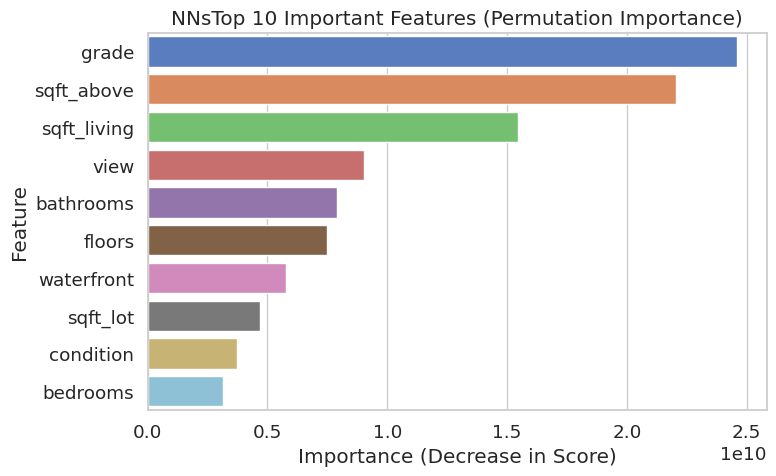

In [67]:
importances = pd.Series(result.importances_mean, index=X_train.columns)

top_importances = importances.head(10).sort_values(ascending=False)
df_imp = top_importances.reset_index()
df_imp.columns = ['Feature', 'Importance']

plt.figure(figsize=(8,5))
sbn.barplot(
    x='Importance',
    y='Feature',
    hue='Feature',
    data=df_imp,
    palette='muted',
    dodge=False,
    legend=False
)
plt.title('NNsTop 10 Important Features (Permutation Importance)')
plt.xlabel("Importance (Decrease in Score)")
plt.tight_layout()
plt.show()


> ***2- Using SHAP***



PermutationExplainer explainer: 4324it [05:10, 13.64it/s]                          
<ipython-input-68-c46a81723746>:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_values, X_test,


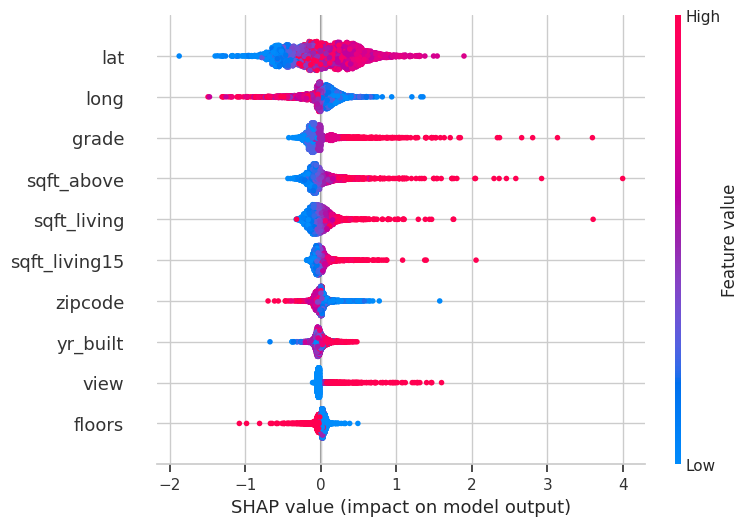

In [68]:
import shap
background = X_full_train[np.random.choice(X_full_train.shape[0], 100, replace=False)]
explainer = shap.Explainer(final_result['model'], background)

shap_values = explainer(X_test_scaled)

shap.summary_plot(shap_values, X_test,
                  feature_names=X_train.columns, max_display=10)

# **4. Compare all models**

In [69]:
rows = []
for name, y_pred in [
    ('Decision Tree', y_pred_test),
    ('Random Forest', y_rf_test_tuned),
    ('Best NN', final_result['y_pred_test']),
]:
    rmse, r2, mean_err, std_err = evaluate_model(y_test, y_pred, name, False)
    rows.append([name, rmse, r2, mean_err, std_err])

results_df = pd.DataFrame(rows, columns=['Model', 'Test RMSE', 'Test R²', 'Mean Error', 'Std Error'])

print("\nModel Performance Summary:")
display(results_df.style.hide(axis="index"))


Model Performance Summary:


Model,Test RMSE,Test R²,Mean Error,Std Error
Decision Tree,181974.643055,0.808149,-6665.584651,181852.524580
Random Forest,153955.693657,0.862680,-2537.452522,153934.781463
Best NN,151669.035162,0.866729,-11861.132328,151204.529585


In [75]:
rmse_tree = np.sqrt(mean_squared_error(y_test, y_pred_test))
r2_tree = r2_score(y_test, y_pred_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_rf_test_tuned))
r2_rf = r2_score(y_test, y_rf_test_tuned)

rmse_nn = np.sqrt(mean_squared_error(y_test, final_result['y_pred_test']))
r2_nn = r2_score(y_test, final_result['y_pred_test'])

model_names = ['Baseline', 'Decision\nTree', 'Random\nForest', 'NN']
rmse_values = [baseline_rmse, rmse_tree, rmse_rf, rmse_nn]
r2_values = [baseline_r2, r2_tree, r2_rf, r2_nn]

results_df = pd.DataFrame({
    'Model': model_names,
    'Test RMSE': [round(x, 2) for x in rmse_values],
    'Test R2': [round(x, 3) for x in r2_values]
})

print("\nModel Performance Comparison:")
print(results_df.to_string(index=False))


Model Performance Comparison:
         Model  Test RMSE  Test R2
      Baseline  415582.67   -0.001
Decision\nTree  181974.64    0.808
Random\nForest  153955.69    0.863
            NN  151669.04    0.867


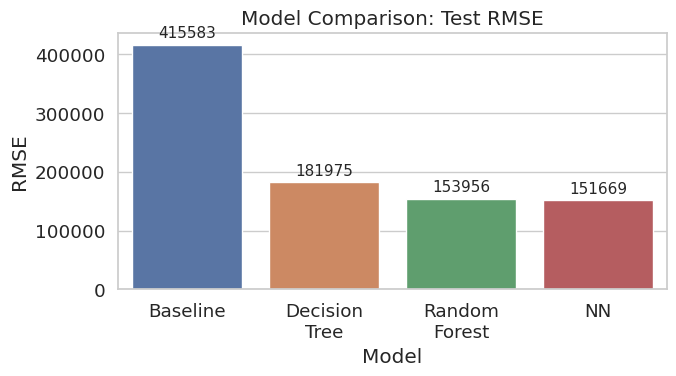

In [77]:
plt.figure(figsize=(7, 4))
ax = sbn.barplot(
    x='Model',
    y='Test RMSE',
    hue='Model',
    data=results_df,
    palette='deep',
    dodge=False,
    legend=False
)
plt.title("Model Comparison: Test RMSE")
plt.ylabel("RMSE")

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=3, fontsize=11)
plt.tight_layout()
plt.show()

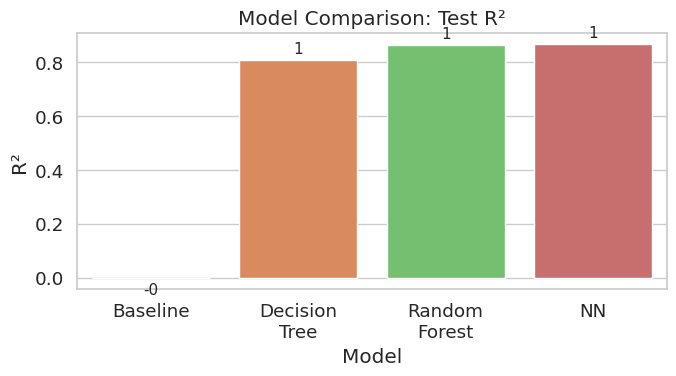

In [81]:
plt.figure(figsize=(7, 4))
ax = sbn.barplot(
    x='Model',
    y='Test R2',
    hue='Model',
    data=results_df,
    palette='muted',
    dodge=False,
    legend=False
)
plt.title("Model Comparison: Test R²")
plt.ylabel("R²")

for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', padding=3, fontsize=11)
plt.tight_layout()
plt.show()